<a href="https://colab.research.google.com/github/dimitarpg13/langchain_tutorial/blob/main/langchain_tutorial/notebooks/llm_and_sql_db/QASystemOverSQLDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question/Answering system over SQL data

### Workflow

1. Convert question to SQL query: Model converts user input to a SQL query.

2. Execute SQL query: Execute the query.

3. Answer the question: Model responds to user input using the query results.


In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langgraph

initialize appropriate env variables

In [2]:
import os, getpass
from dotenv import load_dotenv

def _set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}: ")

load_dotenv()

_set_env("LANGSMITH_API_KEY")

os.environ["LANGSMITH_TRACING"] = "true"

### Sample Data

The below example will use a SQLite connection with the Chinook database, which is a sample database that represents a digital media store. Follow [these installation steps](https://database.guide/2-sample-databases-sqlite/) to create Chinook.db in the same directory as this notebook. You can also download and build the database via the following terminal command lines:

```bash
apt-get install sqlite3

curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```

We interface with the freshly  created `Chinook.db` using the SQLAlchemy-driven `SQLDatabase` class:

In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

Next we define the application state of our chain:

In [4]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

### Convert question into a query

To reliably obtain SQL queries (absent markdown formatting and explanations or clarifications), we will make use of [LangChain's structured output](https://python.langchain.com/docs/concepts/structured_outputs/) abstraction.

In [ ]:
%pip install --upgrade --quiet "langchain[google-genai]"

In [6]:
_set_env("GOOGLE_API_KEY")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

Provide instructions to the model via a query prompt template:

In [7]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()



================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


The prompt includes several parameters we need to populate:

* the sql dialect

* the top_k value

* table schema

The method `write_query` defined below will populate these parameters by prompt a model to generate SQL query

In [8]:
from typing_extensions import Annotated

class QueryOutput(TypedDict):
  """Generated SQL query."""

  query: Annotated[str, ..., "Synthactically valid SQL query."]

def write_query(state: State):
  """Generate SQL query to fetch information."""

  prompt = query_prompt_template.invoke(
      {
          "dialect": db.dialect,
          "top_k": 10,
          "table_info": db.get_table_info(),
          "input": state["question"],
      }
  )
  structured_llm = llm.with_structured_output(QueryOutput)
  result = structured_llm.invoke(prompt)
  return {"query": result["query"]}

Test question:

In [9]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT count(*) FROM Employee'}

### Execute the query

Word of caution: Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution (see below).

The tool `QuerySQLDatabaseTool` from [langchain-community](https://python.langchain.com/docs/concepts/architecture/#langchain-community) will be used to execute the query

In [10]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

Test `execute_query`:


In [11]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

### Generate an answer

the next step generates an answer to the question given the information pulled from the DB

In [12]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### Orchestrate with LangGraph

Construct a single graph object connecting the three steps into a single sequence.

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

Visualize the control flow using th4 LangGraph build-in feature

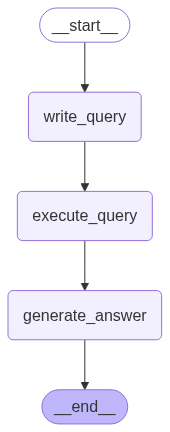

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Test the whole sequence encoded in the chain above:

In [15]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT count(*) FROM Employee'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}
